<a href="https://colab.research.google.com/github/dauvannam321/AI_TEMPORUN_SUMMER2023/blob/main/team09_UIT_CHV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import library**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 18.7 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# **Get data**

In [ ]:
!gdown --id 1OkXUA4IBOhfgmZjw9iejr9c45rY8VlhJ

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1OkXUA4IBOhfgmZjw9iejr9c45rY8VlhJ
To: /content/AugmentDataX5Neutral.csv
100% 591k/591k [00:00<00:00, 140MB/s]


In [ ]:
df = pd.read_csv('AugmentDataX5Neutral.csv')

In [ ]:
df.head(5)

,Unnamed: 0,Comment,Label
0,0,tài liệu được bổ sung nhiều và đầy đủ trên moo...,positive
1,1,giảng viên phải nên cho ví dụ cụ thể những phầ...,positive
2,2,"bài tập đa dạng , cụ thể .",positive
3,3,slide up đầy đủ trước mỗi buổi học .,positive
4,4,"nội dung giảng dạy quá nhàm chán , khô khan .",negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6748 entries, 0 to 6747
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6748 non-null   int64 
 1   Comment     6748 non-null   object
 2   Label       6748 non-null   object
dtypes: int64(1), object(2)
memory usage: 158.3+ KB


In [ ]:
df['Label'].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

<Axes: xlabel='Label', ylabel='count'>

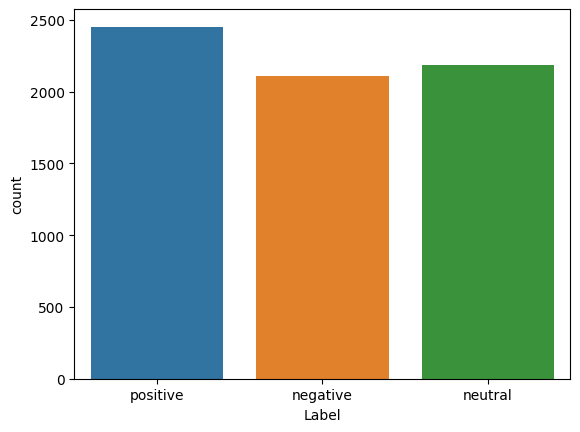

In [ ]:
sns.countplot(x='Label', data=df)

# **Dataloader**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast = False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        label, text = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self, text):
      if text=='positive':
          return 0
      elif text=='negative':
          return 1
      else:
          return 2

    def get_input_data(self, row):
        label = self.labelencoder(row['Label'])

        # Preprocessing: {remove icon, special character, lower}
        text = row['Comment']
        text = ' '.join(simple_preprocess(text))

        return label, text

In [ ]:
comment_data = df.Comment.tolist()
print("Mẫu dữ liệu ban đầu: ",comment_data[106])
preprocess_comment_data = [' '.join(simple_preprocess(text)) for text in comment_data]
print("Mẫu dữ liệu sau khi xử lí: ",preprocess_comment_data[106])
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in preprocess_comment_data]
print(encoded_text[106])

Mẫu dữ liệu ban đầu:  TRUYỀN ĐẠT RẤT DỄ HỈU.
Mẫu dữ liệu sau khi xử lí:  truyền đạt rất dễ hỉu
[0, 1906, 208, 59, 592, 1340, 44831, 2]


Text(0.5, 9.444444444444438, 'Token Count')

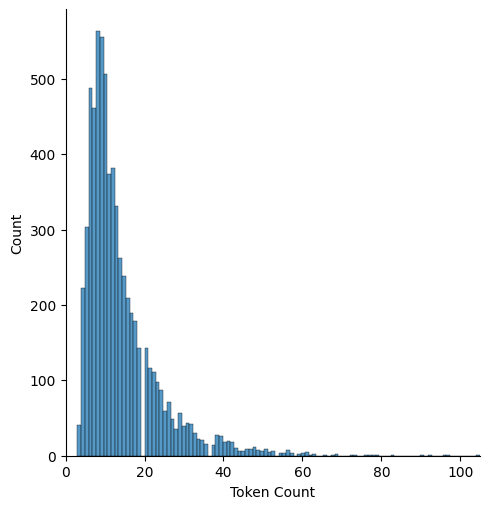

In [ ]:
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

=> Choose a maximum of length of 50 is safe.

In [ ]:
data = SentimentDataset(df, tokenizer, max_len=120)

In [ ]:
print(data[0])

{'text': 'tài liệu được bổ sung nhiều và đầy đủ trên moodle', 'input_ids': tensor([    0,  1941,  1934,    11,  5665,  9324,    36,     6,   545,   312,
           34, 50339, 35547,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,    

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train, df_valid = train_test_split(df_train, test_size=0.22222222222, random_state=42)

In [ ]:
print("Train: ",len(df_train))
print("Valid: ",len(df_valid))
print("Test: ",len(df_test))

Train:  4723
Valid:  1350
Test:  675


In [ ]:
train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)
test_dataset = SentimentDataset(df_test, tokenizer, max_len=120)

In [ ]:
print(train_dataset[0])

{'text': 'không hướng dẫn đồ án', 'input_ids': tensor([  0,  17, 455, 376, 779, 565,   2,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1]), 'attention_masks': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

In [ ]:
for data in train_loader:
  print(data)
  break

{'text': ['cần tăng thời gian thực hành nói lên', 'thầy dạy có tâm nhiệt tình với sinh viên', 'giảng dạy rất chi tiết dễ hiểu và dễ tiếp thu', 'dặn dò sinh viên cần ôn nội dung nào cho buổi học kế tiếp', 'có thể chia nhóm ra làm thực hành', 'không có', 'số buổi ôn tập còn ít', 'cô nhiệt tình tận tâm', 'cần có tài liệu giáo trình của trường một cách cụ thể và cập nhật hơn', 'thực tế với hiện trạng', 'tạo ra sự cạnh tranh trong mỗi buổi thực hành', 'thầy vào lớp trễ kéo dài thời gian dạy học qua tiết trống dạy không đúng với trọng tâm ra đề thi chấm điểm cuối kỳ quá chậm', 'có nhiều nội dung liên quan tới thực tiễn có thể áp dụng vào thực tế sau này', 'vì theo em thầy mọi người đi học rất đầy đủ', 'em xin góp như thế', 'nên xác định điểm quá trình tốt hơn tránh để gian lận'], 'input_ids': tensor([[   0,  115,  128,  ...,    1,    1,    1],
        [   0, 1249,  940,  ...,    1,    1,    1],
        [   0, 5415,  940,  ...,    1,    1,    1],
        ...,
        [   0,   90,   63,  ..., 

# **Model**

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-large")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )

        x = self.drop(output)
        x = self.fc(x)
        # x = self.fc(output)
        return x

# **Train & Eval Function**

In [ ]:
def train(model, criterion, optimizer, train_loader, lr_scheduler):
    model.train()
    running_loss = 0
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        running_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct.double()/len(train_loader.dataset)
    # print(f'Train Accuracy: {epoch_accuracy} Loss: {epoch_loss}')
    return epoch_accuracy, epoch_loss

def eval(model, criterion, test_loader, test_mode=False):
    model.eval()
    running_loss = 0
    correct = 0

    with torch.no_grad():
        data_loader = test_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            running_loss += loss.item()

    epoch_loss = running_loss / len(test_loader)
    epoch_accuracy = correct.double()/len(test_loader.dataset)

    if test_mode == False:
      # print(f'Train Accuracy: {epoch_accuracy} Loss: {epoch_loss}')
      return epoch_accuracy, epoch_loss
    else:
      print(f'Test Accuracy: {epoch_accuracy} Loss: {epoch_loss}')
      return epoch_accuracy, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
  train_losses = []
  valid_losses = []

  current_validAcc = 0

  lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*epochs
            )

  # train model
  for epoch in range(0, epochs):
    # training
    train_acc, train_loss = train(model, criterion, optimizer, train_loader, lr_scheduler)
    train_losses.append(train_loss)

    # validation
    with torch.no_grad():
      valid_acc, valid_loss = eval(model, criterion, valid_loader, test_mode=False)
      valid_losses.append(valid_loss)

      # save model
      if current_validAcc < valid_acc:
        print("Current valid acc {} < valid acc {} of epoch {}".format(current_validAcc, valid_acc, epoch))
        current_validAcc = valid_acc
        # Define the path where you want to save the model's weights
        PATH = "model_weights_final.pt"

        # Save the model's weights
        torch.save(model.state_dict(), PATH)

    if epoch % print_every == print_every - 1:
      print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}\n'.format(
            epoch, train_loss, valid_loss, train_acc, valid_acc))

  return train_losses, valid_losses

In [ ]:
model = SentimentClassifier(n_classes=3).to(device)

Some weights of the model checkpoint at vinai/phobert-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Set hyperparameter
criterion = nn.CrossEntropyLoss()
# Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
# Batchsize: 16, 32
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 10

**Train model**

In [ ]:
history = training_loop(model,criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1)

Current valid acc 0 < valid acc 0.7696296296296296 of epoch 0
Epochs: 0, Train_loss: 0.8627813253174158, Valid_loss: 0.6739856178269666, Train_accuracy: 0.59284353165361, Valid_accuracy: 0.7696296296296296

Current valid acc 0.7696296296296296 < valid acc 0.8874074074074073 of epoch 1
Epochs: 1, Train_loss: 0.4631287395274518, Valid_loss: 0.4344306630356347, Train_accuracy: 0.8435316536099936, Valid_accuracy: 0.8874074074074073

Current valid acc 0.8874074074074073 < valid acc 0.9185185185185185 of epoch 2
Epochs: 2, Train_loss: 0.3084743354765296, Valid_loss: 0.3265226672841784, Train_accuracy: 0.9106500105864916, Valid_accuracy: 0.9185185185185185

Current valid acc 0.9185185185185185 < valid acc 0.9333333333333332 of epoch 3
Epochs: 3, Train_loss: 0.20858578327445415, Valid_loss: 0.26105450412587206, Train_accuracy: 0.9472792716493754, Valid_accuracy: 0.9333333333333332

Epochs: 4, Train_loss: 0.1488438585908404, Valid_loss: 0.3319199748172918, Train_accuracy: 0.9678170654245183, Va

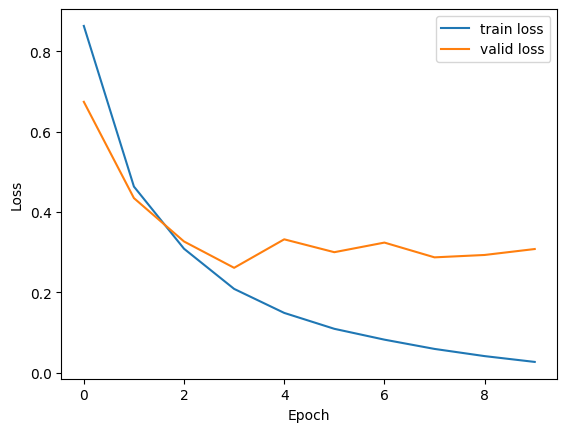

In [ ]:
import matplotlib.pyplot as plt

# Lấy train loss và valid loss từ dictionary history
train_loss = history[0]
valid_loss = history[1]

# Plot train loss và valid loss
plt.plot(train_loss, label='train loss')
plt.plot(valid_loss, label='valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# # Define the path where you want to save the model's weights
# PATH = "model_weights3.pt"

# # Save the model's weights
# torch.save(model.state_dict(), PATH)

**Eval model (Calculate F1 macro)**

In [ ]:
model = SentimentClassifier(n_classes=3).to(device)
model.load_state_dict(torch.load('model_weights_final.pt'))

Some weights of the model checkpoint at vinai/phobert-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def macroF1(test_loader):
  total_output = []
  real_values = []

  for data in test_loader:
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_masks'].to(device)
    targets = data['targets'].to(device)

    with torch.no_grad():
      outputs = model(
                      input_ids=input_ids,
                      attention_mask=attention_mask
              )
      total_output.append(outputs)
      real_values.extend(targets.cpu().numpy())

  result = torch.cat(total_output, dim=0)
  result = result.cpu()

  final_result = torch.argmax(result.cpu(), dim=1).numpy()
  real_values = np.array(real_values)
  # print(final_result)
  # print(real_values)
  # print(type(final_result))
  # print(type(real_values))
  print(classification_report(real_values, final_result))

In [ ]:
macroF1(test_loader)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       264
           1       0.95      0.88      0.91       194
           2       0.92      0.99      0.95       217

    accuracy                           0.94       675
   macro avg       0.94      0.94      0.94       675
weighted avg       0.94      0.94      0.94       675



#**Predict and submit**

In [ ]:
# download test_phase data
# !gdown --id 1fhUsKxlsvF2Ep7bYJG_3BJYK9Tq_Ye_0

# download data_phase_1.txt
# !gdown --id 1tQUdFrbWQPWzJIQei5zdveja4q1eAvU4

# download data_phase_2.txt
!gdown --id 1Gr-_ctWBKi8spCBL8FpJNitSTRckjxhY

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Gr-_ctWBKi8spCBL8FpJNitSTRckjxhY
To: /content/data_phase_2.txt
100% 46.2k/46.2k [00:00<00:00, 46.7MB/s]


In [ ]:
test_phase_df = pd.read_csv('data_phase_2.txt', delimiter='\t', header=None, names=['Comment'])

In [ ]:
test_phase_df.head(5)

,Comment
0,"Tiến sĩ câu giờ, hoàng đế gây mê"
1,Mới học 2 bữa thôi là đã nghiện cách giảng dạy...
2,kêu giơ tay phát biểu cộng điểm nhưng có cái nịt
3,thầy mãi là number one trong lòng em !
4,"Thầy như là người được chọn, sỡ hữu haki bá vư..."


In [ ]:
class SubmitData(Dataset):
  def __init__(self, df, tokenizer, max_len=120):
      self.df = df
      self.max_len = max_len
      self.tokenizer = tokenizer

  def __len__(self):
      return len(self.df)

  def get_input_data(self, row):
      # Preprocessing: {remove icon, special character, lower}
      text = row['Comment']
      text = ' '.join(simple_preprocess(text))

      return text

  def __getitem__(self, index):
      """
      To customize dataset, inherit from Dataset class and implement
      __len__ & __getitem__
      __getitem__ should return
          data:
              input_ids
              attention_masks
              text
      """
      row = self.df.iloc[index]
      text = self.get_input_data(row)

      # Encode_plus will:
      # (1) split text into token
      # (2) Add the '[CLS]' and '[SEP]' token to the start and end
      # (3) Truncate/Pad sentence to max length
      # (4) Map token to their IDS
      # (5) Create attention mask
      # (6) Return a dictionary of outputs
      encoding = self.tokenizer.encode_plus(
          text,
          truncation=True,
          add_special_tokens=True,
          max_length=self.max_len,
          padding='max_length',
          return_attention_mask=True,
          return_token_type_ids=False,
          return_tensors='pt',
      )

      return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_masks': encoding['attention_mask'].flatten(),
      }

In [ ]:
submitdata = SubmitData(test_phase_df, tokenizer, max_len=120)

In [ ]:
submitdata_loader = DataLoader(submitdata, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
# for data in submitdata_loader:
#   print(data)
#   break

In [ ]:
def FinalResult(submitdata_loader, model):
  total_output = []

  for data in submitdata_loader:
    text = data['text']
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_masks'].to(device)

    with torch.no_grad():
      outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask
                    )
      total_output.append(outputs)

  result = torch.cat(total_output, dim=0)
  result = result.cpu()

  final_result = torch.argmax(result.cpu(), dim=1).numpy()
  return final_result

In [ ]:
fin_result = FinalResult(submitdata_loader, model)

In [ ]:
print(fin_result)

[0 2 2 0 1 1 1 2 2 1 1 1 1 0 0 0 2 1 0 1 0 1 2 2 2 2 1 2 1 2 2 0 0 2 2 1 2
 1 2 0 1 2 1 0 1 0 2 2 1 2 0 1 1 2 1 1 0 0 1 1 0 2 2 1 0 2 1 1 1 1 2 2 0 0
 0 1 0 1 0 1 1 2 1 1 0 1 2 0 0 2 0 1 1 1 2 1 1 1 1 2 0 1 0 1 2 0 0 2 0 0 1
 2 2 1 2 0 0 0 2 2 2 0 0 0 1 1 2 0 1 1 2 1 2 0 0 0 1 2 0 1 0 0 0 2 0 0 1 1
 0 2 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 1 2 0 2 0 0 1 0 0 2 2 0 2 1 0 0 2 0 2 1
 0 1 0 0 1 2 1 2 1 0 0 2 1 1 1 0 1 1 0 1 1 2 1 0 0 1 1 0 2 2 2 1 0 1 0 1 0
 1 1 0 0 1 2 1 0 1 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 1 2 1 0 0 2 0 2 2 0 2 2
 2 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 2 0 2 1 1 1 1 1 0 0 1 1 1 2 2 0 0 2 1 1 0
 2 2 0 0 2 0 0 1 2 0 1 2 0 1 1 2 0 2 2 1 1 1 0 0 1 2 2 1 1 2 1 1 2 1 1 0 2
 1 1 0 2 0 0 0 0 2 1 0 2 0 1 2 0 0 1 0 1 1 1 2 0 1 0 0 2 1 0 1 1 1 2 0 1 1
 0 1 1 1 1 0 0 1 2 1 1 1 0 0 2 1 1 1 1 0 1 2 2 1 2 2 1 2 2 1 2 0 1 1 1 0 1
 2 2 2 2 0 0 1 1 1 2 0 0 2 1 0 0 0 1 1 1 2 0 0 1 1 0 0 1 1 1 0 0 1 0 2 1 1
 0 1 2 2 2 1 1 1 0 0 1 0 0 0 1 0 2 0 1 1 2 2 0 0 0 1 0 1 0 2 0 1 0 0 2 2 0
 1 0 1 1 2 1 1 1 0 0 2 0 

In [ ]:
with open('submit.txt', mode='w') as file:
  for i in fin_result:
    if i == 0:
      file.write("positive" + "\n")
    elif i == 1:
      file.write("negative" + "\n")
    else:
      file.write("neutral" + "\n")